# DATA PREPARATION AND LIBRARIES IMPORT

In [1]:
# Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd

# Figures plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# GUI to import data file (xlsx)

In [2]:
root= tk.Tk()

canvas1 = tk.Canvas(root, width = 300, height = 300, bg = 'lightsteelblue2', relief = 'raised')
canvas1.pack()

def getCSV ():
    global df
    
    import_file_path = filedialog.askopenfilename()
    df = pd.read_excel (import_file_path)
    df = pd.DataFrame(df)
    
browseButton_CSV = tk.Button(text="      Import XLSX File     ", command=getCSV, bg='green', fg='white', font=('helvetica', 12, 'bold'))
canvas1.create_window(150, 150, window=browseButton_CSV)

root.mainloop()

In [3]:
df.info() # BW nad BH are standing for body weight and body height, respectively

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     1712 non-null   int64  
 1   Gender  1712 non-null   object 
 2   BW      1712 non-null   float64
 3   BH      1712 non-null   int64  
 4   Wmax    1712 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 67.0+ KB


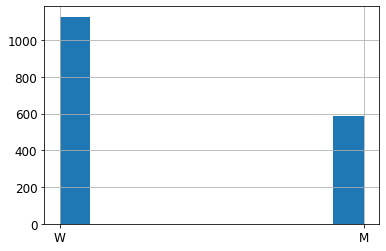

In [4]:
# Histogram of gender distribution
df['Gender'].hist(label=int,align='mid')

## Writing a function for BMI calculation and adding a new column
https://en.wikipedia.org/wiki/Body_mass_index

In [5]:
# Function
def bmi(bw,bh):
    return bw/((bh/100)*(bh/100))

In [6]:
# Adding a new column
df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 

In [7]:
df.describe()

,Age,BW,BH,Wmax,BMI
count,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000
mean,55.765771,75.929030,168.342874,118.494743,26.726015
std,10.930445,16.636734,8.964106,41.874907,5.137146
min,18.000000,38.000000,136.000000,26.000000,15.570934
25%,49.000000,63.000000,162.000000,88.000000,23.183603
50%,56.000000,73.500000,168.000000,112.000000,25.884072
75%,62.000000,86.000000,174.000000,141.000000,29.666548
max,88.000000,143.000000,200.000000,327.000000,49.480969


## Histogram distribution of each attribute

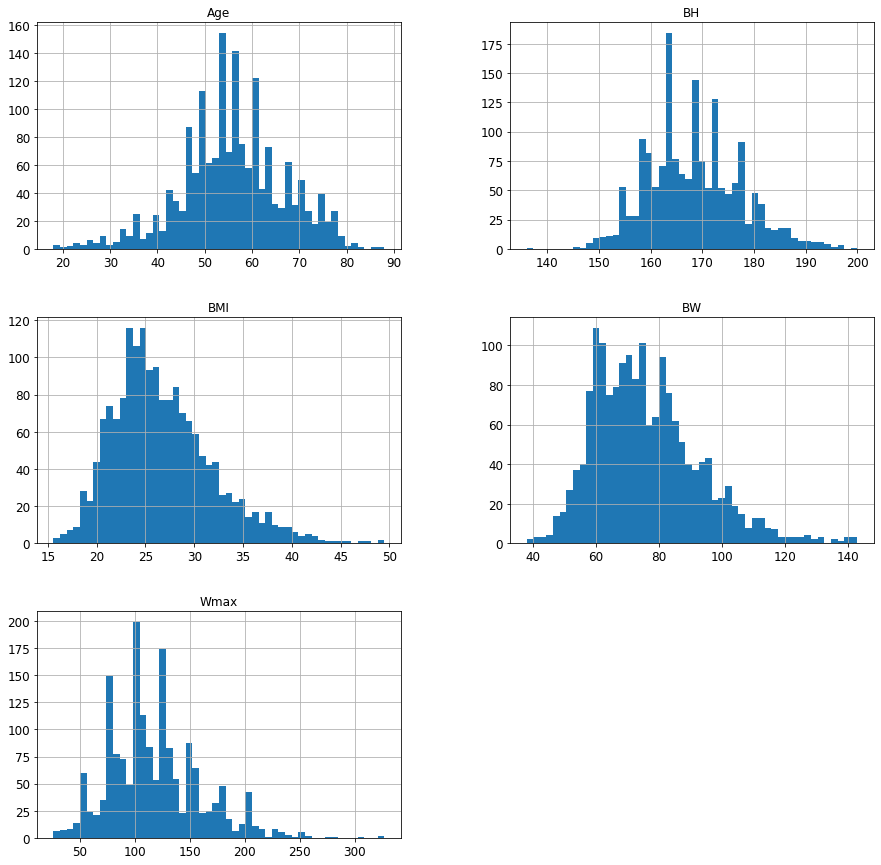

In [8]:
df.hist(bins=50, figsize=(15,15))
plt.show()

In [9]:
np.random.seed(42) # To ensure the repeatability of train/test results. It means that every time we run models the train/test samples will be same

# PREPARING TRAINING AND TEST SET

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_labels = train_set["Wmax"].copy()       # Save a copy of label variable
train_set = train_set.drop("Wmax", axis=1)    # Drop label variable from training set

In [11]:
train_num = train_set.drop('Gender', axis=1)  # Keep only numerical variables

# PIPELINE

In [12]:
# Pipline to scale numerical variables and transform categorical variable (gender) into binary

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
        ('std_scaler', StandardScaler()),])
train_transf = pipeline.fit_transform(train_num)

In [13]:
train_transf # Only numerical variables were scaled (Age, BW, BH and BMI)

array([[-0.15967596, -1.51125216, -0.03854364, -1.69784767],
       [ 0.66694906,  0.47054314,  0.29754705,  0.37277885],
       [ 0.48325461,  0.47054314,  0.18551682,  0.43863677],
       ...,
       [ 1.40172686,  0.05016232, -0.93478547,  0.63533859],
       [ 0.29956016, -0.2501097 ,  0.74566797, -0.64078367],
       [-0.06782874, -0.1900553 , -0.03854364, -0.18335043]])

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(train_num)
cat_attribs = ["Gender"]

full_pipeline = ColumnTransformer([
        ("num", pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),])

train_prepared = full_pipeline.fit_transform(train_set) # Training set is ready for use

In [15]:
train_prepared # Numerical and categorical variables are scaled

array([[-0.15967596, -1.51125216, -0.03854364, -1.69784767,  0.        ,
         1.        ],
       [ 0.66694906,  0.47054314,  0.29754705,  0.37277885,  1.        ,
         0.        ],
       [ 0.48325461,  0.47054314,  0.18551682,  0.43863677,  1.        ,
         0.        ],
       ...,
       [ 1.40172686,  0.05016232, -0.93478547,  0.63533859,  0.        ,
         1.        ],
       [ 0.29956016, -0.2501097 ,  0.74566797, -0.64078367,  0.        ,
         1.        ],
       [-0.06782874, -0.1900553 , -0.03854364, -0.18335043,  0.        ,
         1.        ]])

# SELECTING AND TRAINING THE MODEL

## Linear regression

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
# RMSE for linear model

from sklearn.metrics import mean_squared_error

watt_predictions = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, watt_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE is: ",lin_rmse) # We can see that the prediction error for linear model is 32.5 Watt 

RMSE is:  32.46354580734144


## Support vector regressor (SVR)

In [18]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_prepared, train_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [19]:
# RMSE for SVR model

watt_SVR_predictions = svm_reg.predict(train_prepared)
SVR_mse = mean_squared_error(train_labels, watt_SVR_predictions)
SVR_rmse = np.sqrt(SVR_mse)
print ("RMSE is: ",SVR_rmse) # We can see that the prediction error for linear model is 32.6 Wat

RMSE is:  32.615674028371714


## Random forest model

In [20]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=400, max_features=2, random_state=42, oob_score=True)
forest_reg.fit(train_prepared, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [21]:
# RMSE for random forest model

watt_RF_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(train_labels, watt_RF_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE is: ", forest_rmse) # We can see that the prediction error for linear model is 13.1 Wat (until now the model with lowest prediction error)

RMSE is:  12.75719979090669


# FINE TUNING OF MODELS

'''The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:'''

In [22]:
# Function to display the score statistics

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [23]:
from sklearn.model_selection import cross_val_score

## Linear model

In [24]:
lin_scores = cross_val_score(lin_reg, train_prepared, train_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [30.53455934 27.46985412 38.43562164 32.76486023 38.07501257 31.38868645
 31.97227142 31.11989247 32.31836557 30.94683766]
Mean: 32.50259614886735
Standard deviation: 3.184513995300587


## SVR

In [25]:
SVR_scores = cross_val_score(svm_reg, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

Scores: [31.19126727 27.5297865  38.9271332  33.18049647 38.51193615 31.05314042
 31.92811072 30.98819848 32.00674191 30.15057619]
Mean: 32.54673873052626
Standard deviation: 3.387883572916082


## Random forest

In [26]:
forest_scores = cross_val_score(forest_reg, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [34.29153076 28.13849273 40.23168348 34.69729804 35.87945736 31.28317561
 33.70701509 32.66996518 33.21667897 32.28806087]
Mean: 33.64033581007963
Standard deviation: 2.9796213317433775


In [27]:
# Return the table of cross-validation for all three models

scores = cross_val_score(lin_reg,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
scores_rf = cross_val_score(forest_reg,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
scores_svr = cross_val_score(svm_reg,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
a = pd.Series(np.sqrt(-scores)).describe()
b = pd.Series(np.sqrt(-scores_svr)).describe()
c = pd.Series(np.sqrt(-scores_rf)).describe()
scores_df = pd.DataFrame({
    "lin_reg": a,
    "SVR":b,
    "forest_reg": c
    
})
scores_df

,lin_reg,SVR,forest_reg
count,10.000000,10.000000,10.000000
mean,32.502596,32.546739,33.640336
std,3.356772,3.571143,3.140797
min,27.469854,27.529786,28.138493
25%,30.990101,31.004434,32.383537
50%,31.680479,31.559689,33.461847
75%,32.653237,32.887058,34.595856
max,38.435622,38.927133,40.231683


''' We can see that linear and SVR models perform a slightly better than rendom forest'''

# OPTIMIZATION OF RANDOM FOREST HYPERPARAMETERS

In [28]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 100, 200, 300, 400, 500, 600, 700, 800, 900], 'max_features': [2,3,4,5,6]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 100, 200, 300, 400, 500], 'max_features': [2, 3, 4, 5, 6]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_prepared, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [29]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 400}

In [30]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [31]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

38.4940117217386 {'max_features': 2, 'n_estimators': 3}
34.90664448964283 {'max_features': 2, 'n_estimators': 10}
34.112257079462694 {'max_features': 2, 'n_estimators': 30}
33.71228650396655 {'max_features': 2, 'n_estimators': 100}
33.73657088407818 {'max_features': 2, 'n_estimators': 200}
33.75496753226883 {'max_features': 2, 'n_estimators': 300}
33.687204371747136 {'max_features': 2, 'n_estimators': 400}
33.74119199337895 {'max_features': 2, 'n_estimators': 500}
33.73737302333843 {'max_features': 2, 'n_estimators': 600}
33.73858230123721 {'max_features': 2, 'n_estimators': 700}
33.72843675722854 {'max_features': 2, 'n_estimators': 800}
33.72881899375732 {'max_features': 2, 'n_estimators': 900}
38.07093598414351 {'max_features': 3, 'n_estimators': 3}
35.283895120383214 {'max_features': 3, 'n_estimators': 10}
34.19180529853965 {'max_features': 3, 'n_estimators': 30}
33.79365543398837 {'max_features': 3, 'n_estimators': 100}
33.72827150975516 {'max_features': 3, 'n_estimators': 200}
33.

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_prepared, train_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [42]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'max_features': 7, 'n_estimators': 180}
34.82414849047345 {'max_features': 5, 'n_estimators': 15}
33.831655099381045 {'max_features': 3, 'n_estimators': 72}
34.51692729880591 {'max_features': 5, 'n_estimators': 21}
nan {'max_features': 7, 'n_estimators': 122}
33.825156929457506 {'max_features': 3, 'n_estimators': 75}
33.794862854326254 {'max_features': 3, 'n_estimators': 88}
33.92581550398184 {'max_features': 5, 'n_estimators': 100}
33.70397946438795 {'max_features': 3, 'n_estimators': 150}
40.79093345338655 {'max_features': 5, 'n_estimators': 2}


# FEATURE IMPORTANCE

In [33]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.27592597, 0.18085386, 0.2452533 , 0.18479749, 0.06101275,
       0.05215662])

In [34]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2759259745361203, 'Age'),
 (0.24525330384500102, 'BH'),
 (0.18479749151737487, 'BMI'),
 (0.18085385764595108, 'BW'),
 (0.06101274938925046, 'M'),
 (0.05215662306630235, 'W')]

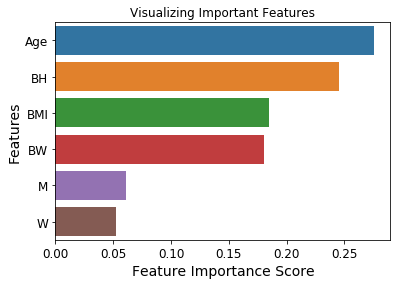

In [35]:
import seaborn as sns

feature_imp = pd.Series(feature_importances,index=attributes).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# TESTING THE MODEL

In [36]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Wmax", axis=1)
y_test = test_set["Wmax"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [37]:
final_rmse

33.81600011112091

In [38]:
from sklearn import metrics
from sklearn.metrics import r2_score

y_oob = final_model.predict(X_test_prepared)
print("R2",r2_score(y_test, y_oob)) # Amount of the variation in the response variable which is predictable from the input independent variable
print("R2",final_model.oob_score)

R2 0.3388450705198016
R2 False


In [39]:
from scipy import stats
# 95% confidence interval for the test RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([30.70822363, 36.66127014])

# PREDICTING Wmax

In [40]:
import warnings
warnings.filterwarnings("ignore")

age = input("Please enter the AGE: ")
age = int(age)
print("Age is: ", age)

bmi = input ("Please ebter the BMI: ")
bmi = int(bmi)
print("BMI is: ", bmi)

bh = input("Please enter the BODY HEIGHT: ")
bh = int(bh)
print("Body height is: ", bh)

bw = input("Please enter the BODY WEIGHT: ")
bw = int(bw)
print("Body weight is: ", bw)

g = input("Please enter your gender(W for women or M for man): ").upper()
print("Gender is: ", g)

a = pd.DataFrame({'Age':[age],'BMI':[bmi],'Gender':[g],'BH':[bh],'BW':[bw]})
b = full_pipeline.transform(a)
print("Your predicted Wmax is: ",int(final_model.predict(b)))

Age is:  45
BMI is:  27
Body height is:  180
Body weight is:  87
Gender is:  W
Your predicted Wmax is:  138
